# Lesson 5b: Recurrent Neural Networks: Categorization

Recurrent Neural Networks (RNNs) can be used in many different ways, such as classification, single-step prediction, and the generation of an entire sequence. 

* **Classification**: the input is a sequence, and the output is a single category - this is the focus of this assignment. (Alternatively, a sequence of categories could be generated, one for each partial sequence as it is processed).

* **Prediction**: the input is a sequence, and the output is a prediction for the next element in the sequence. You will explore this in lesson 5b.

* **Sequence Generation** (Seq-to-Seq): both the input and the output are entire sequences. For example, RNN-based language translation may take in an input sequence (of characters or word tokens) in English, and generate as output a sequence (of characters or word tokens) in French.

RNNs can be used to process inputs that occur naturally in time (such as an audio recording of speech or music represented as a stream of timestamped MIDI messages), but they can also be applied to material that has an order to it, even if it's not necessarly temporal in natures, such as written text (which can be read one character or one word at a time) or even written numbers or math equations (which can be read one digit or symbol at a time, from left to right, for instance.)  This is the problem we investigate today: looking at numbers such as "1423" as a sequence of digits ['1', '4', '2', '3'].

Our problem comes curtosy of Distinguished Professor Douglas R. Hofstadter of Indiana University, author of books such as _Gödel, Escher, Bach: an Eternal Golden Braid_. Hofstadter writes [private communication, shared with permission)]:

---

_Lately, I have been musing about the seeming power of deep neural nets.  They learn to recognize members of all sorts of categories, when those members (and non-members) are fed to them as patterns of symbols or of pixels.  So, how about the following challenges involving the natural numbers?_

* To recognize the even numbers, expressed in base 3.
     (Specifically, 0, 2, 11, 20, 22, 101, 110, 112,...)
* To recognize the multiples of 3, expressed in base 10.
* To recognize the multiples of 9, expressed in base 10.
* To recognize the multiples of 7, expressed in base 10.
* To recognize the multiples of 29, expressed in base 10.

_(I suppose that if a net can learn any particular one of the above list, it can learn all of them.  Just a guess...)_

 _Moving right along, how about the following somewhat harder challenges?_

* To recognize the correct integer additions, expressed either in base 2 or in base 10.  (For example, the string “12+29=41”.)
* To recognize the correct integer multiplications, expressed either in base 2 or in base 10.  (For example, the string “12x29=348”.)

_(The latter of this pair seems significantly harder than the former.)_
     
_And then, of course, the canonical challenge of this sort:_

* To recognize the prime numbers, expressed either in base 2 or in base 10.

_Each of the above challenges involves a number-theoretical category that can easily be described in purely syntactic terms (i.e., as a rule-based pattern of symbols).  It would be trivial to generate millions of examples of such categories mechanically, and then you just feed them to the neural net.  You can also feed the network lots of counterexamples -- marking them, of course, as non-members of the category.  Can a deep neural network learn any of these categories?  All of them?  Some of them?_

---

In this assignment, you will use an RNN to try to solve the divisibility-by-3 problem (the rest are challenges you might want to try in your free time!): 

* **"To recognize the multiples of 3, expressed in base 10."**  Specifically, you must:
    * Design an RNN that takes a sequence of digits as input. 
    * Represent digits in base 10 by using a categorical, one-hot encoding, with one node for each digit from 0 through 9.
    * Train the RNN to categorize a number as True if it is evenly divisible by 3, False otherwise.
    * Test the RNN on a set of previously-unseen numbers, including numbers that are 4 digits long, such as 2225 and 3333.
    * Acheive an accuracy of at least 95% on the test set (report the accuracy in the cell marked below).
    * Answer the questions at the end of this notebook.




# Setup
## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
%matplotlib inline
from keras.models import Model, Sequential, load_model
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [3]:
#Set up params for dataset.
DIVISIBILITY_NUMBER = 3         # We want to test for divisilibity by 3.
TRAIN_TEST_SPLIT = 0.7          # Percentage of data in training set
NUM_EXAMPLES_PER_CLASS = 1000      # Generate the first 1000 multiples of 3 for training/testing
                                # Also generate 1000 non-multiples of 3.
NUM_CATEGORIES = 10             # 10 digits
MAX_DIGITS = 5                  # Number of digits allowed in input strings

# Neural net hyperparameters-- just an example. Adjust these as needed.
BATCH_SIZE = 8
NUM_LSTM_NODES = 32             
DROPOUT = 0.0
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

# TODO: add/modify constants as needed


## Helper functions to generate the dataset of training/testing examples

In [4]:
def generate_example_numbers(base_number=DIVISIBILITY_NUMBER, num_examples_per_class=NUM_EXAMPLES_PER_CLASS):
    """Return a tuple of two lists: (list_of_multiples, list_of_nonmultiples).
    
    For example, ([0, 3, 6, 9, 12, ...2997], [1, 4, 5, 8, 11, 13, 14,...,2999]).
    Each list contains num_examples_per_class elements.
    """
    # Create array of numbers from 0 to num_examples_per_class-1 and multiply by base_number to create multiples
    multiples = np.array(range(num_examples_per_class))*base_number
    # Add one to each number to create non_multiples
    non_multiples = multiples+1

    # Convert from numpy array back to list for export
    multiples = list(multiples)
    non_multiples = list(non_multiples)

    return (multiples, non_multiples)

In [5]:
def generate_labels(size_multiples, size_non_multiples):
    """Return two list of labels one for the True case (multiples) and one for the False case (nonmultiples).
    
    Represent True as 1, False as 0.
    For example, return ([1, 1, 1, 1.....], [0, 0, 0, 0, ....]) with each list the requested size.
    """
    
    true_labels = list(np.ones(size_multiples))
    false_labels = list(np.zeros(size_non_multiples))
    
    return (true_labels, false_labels)

In [6]:
def digit_to_vector(digit):
    """Given a digit from 0-9, return a numpy array representing the digit using a 1-hot encoding.
    keras.utils.to_categorical may be useful.
    """
    return to_categorical(digit,NUM_CATEGORIES)

Let's make sure the digit_to_vector function works as intended:

In [7]:
print(digit_to_vector(5))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
def number_to_input_example(number, max_digits=MAX_DIGITS):
    """Given an integer number, return a numpy float array of 0.0s and 1.0s, of the correct shape to feed into the 
    neural net.
    
    For example, if you have a max of 5 digits then you should have a 2D numpy matrix: 5 rows (one for each
    sequence index), and 10 columns (1 for each digit).
    
    In order to train in "batch" mode, the RNN expects every example to have the same shape. So if you have a 2-digit
    number such as "42", you need to pad the example with a "padding" token somehow; for example, "???42", and then
    use keras.layers.Masking to ignore the leading digits. Or just pad with 0s, as in "00042". 
    keras.preprocessing.sequence.pad_sequences can help with this.
    """
    
    # Create 2D output array
    output = np.zeros((max_digits,NUM_CATEGORIES))
    # Set first column to represent zeros (fill with ones)
    output[:,0] = 1
    # Because of variable size, fill last row first
    # Process number from right to left
    k = 1
    while number > 0:
        # Return modulo 10 to get next digit
        digit = number % 10
        row = digit_to_vector(digit)
        output[-k,:] = row
        k += 1
        # Integer division by 10 to reduce number
        number //= 10
    
    return output

def generate_dataset(divisibility_number=DIVISIBILITY_NUMBER, train_test_split=TRAIN_TEST_SPLIT, 
                     num_examples_per_class=NUM_EXAMPLES_PER_CLASS):
    """Generate a dataset ready for training. Returns a list of tuples. Each tuple is of the form
    (input_array, label). The dataset should be shuffled either here or during the training process to
    mix divisible-by-DIVISIBILITY_NUMBER and not-divisible-by-DIVISIBILITY_NUMBER examples.
    The dataset should consist of NUM_EXAMPLES_PER_CLASS positive examples (e.g., 1000 examples of divisible-by-3), and
    also NUM_EXAMPLES_PER_CLASS negative examples (e.g., 1000 examples of not-divisible-by-3).
    """
    
    # Generate numbers
    numbers = generate_example_numbers(divisibility_number, num_examples_per_class)
    # Generate labels
    labels = generate_labels(num_examples_per_class, num_examples_per_class)
    
    # Combine examples into single lists
    numbers = numbers[0] + numbers[1]
    labels = labels[0] + labels[1]
    # Shuffle before processing
    x = list(range(len(numbers)))
    np.random.shuffle(x)
    
    dataset = []
    # Process in shuffled order
    for index in x:
        num_array = number_to_input_example(numbers[index])
        label = labels[index]
        dataset.append((num_array, label))
    
    return dataset

Let's make sure the number_to_input_example function works as intended:

In [9]:
number_to_input_example(543)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## Helper functions to generate the model

In [10]:
# Build RNN model.
def build_model():
    model = Sequential()
    model.add(LSTM(NUM_LSTM_NODES, dropout=DROPOUT, input_shape=(MAX_DIGITS,NUM_CATEGORIES), return_sequences=False))  # Use return_sequences=True for multiple hidden layers    
    model.add(Dense(48, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Model should return 1 or 0 for divisible/not-divisible
    return model

In [11]:
# Print the model configuration.
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 49        
Total params: 7,137
Trainable params: 7,137
Non-trainable params: 0
_________________________________________________________________


# Generate dataset and model

In [12]:
data = generate_dataset()
X = [d[0] for d in data]
y = [d[1] for d in data]

In [13]:
# Index to split training/validation data (70/30)
idx = int(np.floor(len(X)*TRAIN_TEST_SPLIT))

In [14]:
# Split training validation sets accordingly
train_inputs = np.array(X[:idx])
train_labels = np.array(y[:idx])
validation_inputs = np.array(X[idx:])
validation_labels = np.array(y[idx:])

Let's verify the train and validation data set shapes:

In [15]:
print(train_inputs.shape)
print(validation_inputs.shape)

(1400, 5, 10)
(600, 5, 10)


In [16]:
print(train_labels.shape)
print(validation_labels.shape)

(1400,)
(600,)


Let's also make sure the divisible and non-divisible examples are evenly distributed between the training and validation sets:

In [17]:
sum(train_labels)/len(train_labels)

0.5021428571428571

In [18]:
sum(validation_labels)/len(validation_labels)

0.495

In [19]:
# Compile model
adam = Adam(lr=LEARNING_RATE)   # Modify learning algorithm as needed
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model

In [20]:
# Fit the model
history = model.fit(train_inputs, train_labels, validation_data=(validation_inputs,validation_labels), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=1)

Train on 1400 samples, validate on 600 samples
Epoch 1/20
1400/1400 [==============================] - 2s 1ms/step - loss: 0.6950 - acc: 0.4793 - val_loss: 0.6934 - val_acc: 0.4917
Epoch 2/20
1400/1400 [==============================] - 1s 956us/step - loss: 0.6939 - acc: 0.4779 - val_loss: 0.6938 - val_acc: 0.4750
Epoch 3/20
1400/1400 [==============================] - 1s 951us/step - loss: 0.6936 - acc: 0.4786 - val_loss: 0.6938 - val_acc: 0.4883
Epoch 4/20
1400/1400 [==============================] - 1s 956us/step - loss: 0.6926 - acc: 0.5093 - val_loss: 0.6930 - val_acc: 0.5333
Epoch 5/20
1400/1400 [==============================] - 1s 949us/step - loss: 0.6913 - acc: 0.5886 - val_loss: 0.6907 - val_acc: 0.6100
Epoch 6/20
1400/1400 [==============================] - 1s 975us/step - loss: 0.6865 - acc: 0.6093 - val_loss: 0.6815 - val_acc: 0.7200
Epoch 7/20
1400/1400 [==============================] - 1s 951us/step - loss: 0.6689 - acc: 0.7121 - val_loss: 0.6399 - val_acc: 0.8367
Epo

Report your final accuracy on the validation dataset below.

Final validation set accuracy = 100%

## Examine model outputs

Let's print the predicted and actual labels for the first 10 observations.

In [21]:
# Examine the outputs of the model on some test data.
[model.predict(np.expand_dims(validation_inputs[i], 0)) for i in range(10)]

[array([[0.00424126]], dtype=float32),
 array([[0.9959558]], dtype=float32),
 array([[0.99725586]], dtype=float32),
 array([[0.9983032]], dtype=float32),
 array([[0.00912879]], dtype=float32),
 array([[0.99905056]], dtype=float32),
 array([[0.99843293]], dtype=float32),
 array([[0.99665314]], dtype=float32),
 array([[0.9991222]], dtype=float32),
 array([[0.9971424]], dtype=float32)]

In [22]:
print(validation_labels[:10])

[0. 1. 1. 1. 0. 1. 1. 1. 1. 1.]


As an additional check, let's compute the validation accuracy for the first 100 samples.

In [23]:
samples = 100
predicted_vals = [model.predict(np.expand_dims(validation_inputs[i], 0)) for i in range(samples)]
predicted = [np.rint(x[0][0]) for x in predicted_vals]
actual = validation_labels[:samples]
sum(abs(predicted-actual) == 0)/len(predicted) * 100

100.0

The accuracy is 100%, which matches the validation accuracy from the training report.

In addition, let's compute the results of the first 100 numbers, many of which were not in the training or validation sets.

In [24]:
# Plot some results
results = []
lo = 0
hi = 100
rng = range(lo,hi)
for num in rng:
    # Hint: to run on a single example, you can use "np.expand_dims" to add an extra 
    # dimension to a 2D array, in order to make a "batch" of 1.
    #
    # TODO something like this:
    results.append(model.predict(np.expand_dims(number_to_input_example(num), 0))[0][0])

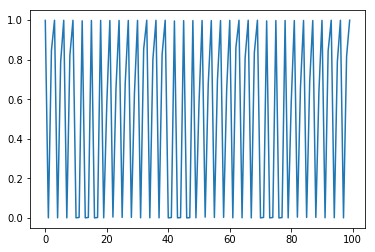

In [25]:
plt.plot(rng[:100], results[:100])
plt.show()

The results are all close to 1 for divisible samples and 0 for indivisible samples, meaning the network reported high confidence in its predictions.

As an additional check, let's plot the training/validation loss and accuracy. Note that the accuracy smoothly approaches 100% and the loss smoothly approaches 0 for both the training and validation sets.

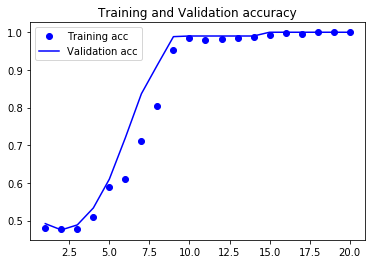

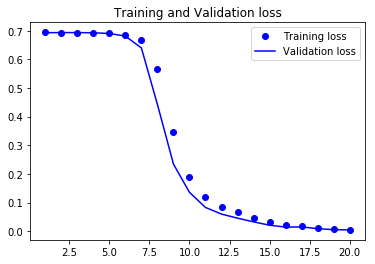

In [26]:
# Plot accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

# Further Questions

1) What happens if you give a 5-digit number or a 6-digit number to the trained model, after training on 1-, 2-, 3-, and 4- digit numbers?

Since our maximum number of digits was 5, let's run a test to see how the network does when predicting a five digit number. We can't use a six digit number because we can't format it properly. 

Let's try two numbers: 11,997, which is divisible by 3, and 11,998, which is not.

In [27]:
# Five digit number that is divisible by three
model.predict(np.expand_dims(number_to_input_example(11997), 0))[0][0]

0.99623716

In [28]:
# Five digit number that is NOT divisible by three
model.predict(np.expand_dims(number_to_input_example(11998), 0))[0][0]

0.019483972

The network returned a probability close to 1 (0.996) for the five digit number that is divisible by three, and a probability close to 0 (0.019) for the five digit number that is not divisible by three. This suggests it is able to handle five digit numbers despite not seeing any during training.

2) Pick another number from Hofstadter's list above, such as 9, 7, or 29. Train a model, and report the accuracy of your results. Did it work or not? Why or why not (your best guess)?

Let's try divisibility by 7 first.

In [29]:
# Change divisibility to 7
DIVISIBILITY_NUMBER = 7

# Generate a new model
model_div7 = build_model()
model_div7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_3 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 49        
Total params: 7,137
Trainable params: 7,137
Non-trainable params: 0
_________________________________________________________________


In [30]:
data_div7 = generate_dataset(DIVISIBILITY_NUMBER)
X_div7 = [d[0] for d in data_div7]
y_div7 = [d[1] for d in data_div7]

In [31]:
# Split training validation sets accordingly
train_inputs_div7 = np.array(X_div7[:idx])
train_labels_div7 = np.array(y_div7[:idx])
validation_inputs_div7 = np.array(X_div7[idx:])
validation_labels_div7 = np.array(y_div7[idx:])

In [32]:
# Compile model
adam = Adam(lr=LEARNING_RATE)   # Modify learning algorithm as needed
model_div7.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [33]:
# Fit the model
history_div7 = model_div7.fit(train_inputs_div7, train_labels_div7, validation_data=(validation_inputs_div7,validation_labels_div7), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=1)

Train on 1400 samples, validate on 600 samples
Epoch 1/20
1400/1400 [==============================] - 2s 1ms/step - loss: 0.6944 - acc: 0.4821 - val_loss: 0.6950 - val_acc: 0.4600
Epoch 2/20
1400/1400 [==============================] - 1s 956us/step - loss: 0.6938 - acc: 0.4921 - val_loss: 0.6957 - val_acc: 0.4533
Epoch 3/20
1400/1400 [==============================] - 1s 966us/step - loss: 0.6933 - acc: 0.5014 - val_loss: 0.6967 - val_acc: 0.4433
Epoch 4/20
1400/1400 [==============================] - 1s 966us/step - loss: 0.6931 - acc: 0.4979 - val_loss: 0.6976 - val_acc: 0.4433
Epoch 5/20
1400/1400 [==============================] - 1s 979us/step - loss: 0.6928 - acc: 0.5064 - val_loss: 0.6969 - val_acc: 0.4383
Epoch 6/20
1400/1400 [==============================] - 1s 972us/step - loss: 0.6925 - acc: 0.5121 - val_loss: 0.6989 - val_acc: 0.4167
Epoch 7/20
1400/1400 [==============================] - 1s 958us/step - loss: 0.6929 - acc: 0.5171 - val_loss: 0.7004 - val_acc: 0.4267
Epo

At the last epoch, the validation set accuracy was only 43%. This did not appear to work, the model was not able to learn the divisibility by 7 rules. Just to be sure, let's try divisibility by 9.

In [34]:
# Change divisibility to 9
DIVISIBILITY_NUMBER = 9

# Generate a new model
model_div9 = build_model()
model_div9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5504      
_________________________________________________________________
dense_5 (Dense)              (None, 48)                1584      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 49        
Total params: 7,137
Trainable params: 7,137
Non-trainable params: 0
_________________________________________________________________


In [35]:
data_div9 = generate_dataset(DIVISIBILITY_NUMBER)
X_div9 = [d[0] for d in data_div9]
y_div9 = [d[1] for d in data_div9]

In [36]:
# Split training validation sets accordingly
train_inputs_div9 = np.array(X_div9[:idx])
train_labels_div9 = np.array(y_div9[:idx])
validation_inputs_div9 = np.array(X_div9[idx:])
validation_labels_div9 = np.array(y_div9[idx:])

In [37]:
# Compile model
adam = Adam(lr=LEARNING_RATE)   # Modify learning algorithm as needed
model_div9.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [38]:
# Fit the model
history_div9 = model_div9.fit(train_inputs_div9, train_labels_div9, validation_data=(validation_inputs_div9,validation_labels_div9), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=1)

Train on 1400 samples, validate on 600 samples
Epoch 1/20
1400/1400 [==============================] - 2s 1ms/step - loss: 0.6946 - acc: 0.4757 - val_loss: 0.6943 - val_acc: 0.4750
Epoch 2/20
1400/1400 [==============================] - 1s 965us/step - loss: 0.6934 - acc: 0.5000 - val_loss: 0.6949 - val_acc: 0.4450
Epoch 3/20
1400/1400 [==============================] - 1s 957us/step - loss: 0.6928 - acc: 0.5157 - val_loss: 0.6953 - val_acc: 0.4683
Epoch 4/20
1400/1400 [==============================] - 1s 966us/step - loss: 0.6911 - acc: 0.5321 - val_loss: 0.6950 - val_acc: 0.4783
Epoch 5/20
1400/1400 [==============================] - 1s 965us/step - loss: 0.6878 - acc: 0.5500 - val_loss: 0.6928 - val_acc: 0.5183
Epoch 6/20
1400/1400 [==============================] - 1s 965us/step - loss: 0.6784 - acc: 0.6293 - val_loss: 0.6838 - val_acc: 0.5800
Epoch 7/20
1400/1400 [==============================] - 1s 977us/step - loss: 0.6517 - acc: 0.6829 - val_loss: 0.6563 - val_acc: 0.6600
Epo

At the last epoch, the validation set accuracy is over 99%. This worked, and the model was able to learn the divisibility by 9 rules.

My best guess as to why 3 and 9 worked, and 7 didn't, has to do with the divisibility rules for each number. 
* A number is divisible by 3 if the $sum$ of its digits is divisible by 3. 
* The same goes for 9, a number is divisible by 9 if the $sum$ of its digits is divisible by 9. 
* The rule for divisiblity by 7 is more complicated. To determine if a number is divisible by 7, remove the last digit, double it, and subtract the result from the remaining number. If that number is divisible by 7, so was the original number.

A RNN works by looping over timesteps and processing sequences of data, computing the output at each timestep using data from the previous timestep plus data from the current timestep. This additive behavior is conducive to learning rules for divisibility by 3 or 9, since they are based on additive operations. The structure of the RNN is not conducive to learning rules for divisibility by 7 as they are based on more complicated operations (trunation and division, specificially).  

3) Record any other comments/insights from your model training process. What worked well? What caused trouble?

During my model training process, here's what worked well, and conversely, what caused trouble:

* Keeping the model simple worked well. I ended up only using one LSTM layer and one dense layer. The model would still converge after adding an additional LSTM layer, but it also performed well without it, so I removed it in the name of simplicity. Adding too much complexity led to poor performance.
* Keeping the learning rate low worked well. If the learning rate was too high the model was unable to follow the gradient smoothly, and the accuracy would get stuck near the random guess baseline of 50% (for binary classification).
* Removing dropout worked well. I started training with the default dropout setting of 0.5, but soon realized that if the model is not displaying signs of overfitting (which it wasn't), there was no need to add dropout. Reducing and finally removing dropout led to a big gain in performance.
* Increasing the number of LSTM nodes to 32 worked well. Too few led to performance issues, as the model did not have enough complexity to learn the divisibility rules.
* Using too few nodes in the dense layer caused trouble. Specifically, using fewer nodes than the LSTM layer cause the loss function to stagnate. Increasing the number of nodes to a few more than the LSTM layer helped the model tremendously.
* Using a smaller batch size worked well, one that was too large or too small caused performance issues with the model.

4) If you didn't have a training algorithm, how would you design a RNN-style system to recognize divisibility by 3?
Ignoring the details of the weights, what kind of state must be carried over from step to step as each digit is read in
successively?

If I was to design my own RNN-style algorithm to recognize divisibility by three, I would read in the number one digit at a time, as we did here. After each sequence, I would carry over the current sum of the digits read so far to the next state. I would initialize the carry over value to zero at first, then add the first digit and carry the sum to the second step, where I would add the second digit and carry the sum to the third step, etc. After the final step, I would check whether the total sum is divisible by three (if the sum is denoted by s, I would compute "s modulo 3" and check if it was equal to zero to denote divisibility by three). In RNN terms, the output of the RNN would be the current sum, which would become the state for the next element in the sequence.

5) BONUS (hard): Explain how the neural net you trained above works, with evidence from examining the node activations as the net runs. Does it do anything similar to what you would have designed as a human?

To try and answer this, let's look at the activations from the dense layer (these are fed to the output layer and a probability is produced via the sigmoid activation). To do this, we'll create a new model using the weights of the previously trained model and get the node activations.

In particular, let's look at two examples, one that's divisible by three and one that's not.

In [308]:
model_diagnostic = Sequential()
model_diagnostic.add(LSTM(NUM_LSTM_NODES, dropout=DROPOUT, input_shape=(MAX_DIGITS,NUM_CATEGORIES), return_sequences=False, weights=model.layers[0].get_weights()))  # Use return_sequences=True for multiple hidden layers 
model_diagnostic.add(Dense(48, activation='relu', weights=model.layers[1].get_weights()))
activations1 = model_diagnostic.predict(np.expand_dims(number_to_input_example(3), 0))

Let's look at the activations (there are 48 because of the 48 dense nodes).

In [309]:
activations1

array([[0.        , 0.00927135, 1.1682644 , 0.        , 0.        ,
        3.9357522 , 0.        , 0.        , 0.        , 0.08311289,
        0.        , 0.        , 0.        , 0.17626657, 0.        ,
        3.2402065 , 0.        , 0.        , 0.        , 0.11079621,
        0.        , 0.1187693 , 0.15067059, 0.05188487, 0.01576122,
        2.3894532 , 0.        , 0.        , 0.        , 0.13994828,
        0.        , 0.        , 2.9263024 , 3.5692434 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.8767538 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.03474749, 0.        ]], dtype=float32)

Other than noting the sparsity, these are not particularly insightful. Let's plot them.

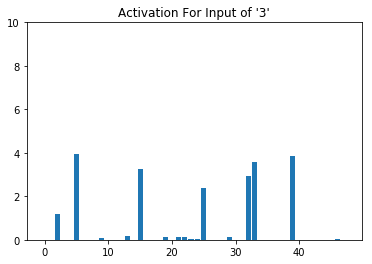

In [310]:
plt.bar(list(range(activations1.shape[-1])),activations1[0])
plt.ylim([0,10])
plt.title('Activation For Input of \'3\'')
plt.show()

Next, let's look at the activations for a number that's not divisible by 3 and plot the same results.

In [311]:
activations2 = model_diagnostic.predict(np.expand_dims(number_to_input_example(4), 0))

In [312]:
activations2

array([[0.        , 0.9148389 , 0.04124343, 0.        , 0.        ,
        4.7224813 , 0.        , 0.0752714 , 0.        , 1.6049025 ,
        0.        , 0.        , 0.        , 0.8090172 , 0.        ,
        0.75411195, 0.        , 0.        , 0.        , 3.547547  ,
        0.        , 2.7413685 , 1.8003172 , 1.4638648 , 2.2379916 ,
        0.2422885 , 0.        , 0.        , 0.        , 0.8980133 ,
        0.        , 0.        , 3.2697895 , 3.8664684 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 2.9963987 ,
        0.        , 0.00578071, 0.        , 0.        , 0.        ,
        0.        , 2.6840148 , 0.        ]], dtype=float32)

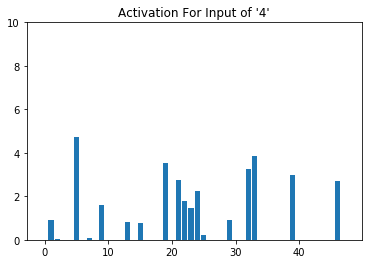

In [313]:
plt.bar(list(range(activations2.shape[-1])),activations2[0])
plt.ylim([0,10])
plt.title('Activation For Input of \'4\'')
plt.show()

Comparing the two plots, it's clear that the example which is not divisible by three has a somewhat less sparse activation tensor, particularly near the middle. To see this, we can plot the difference between the two tensors.

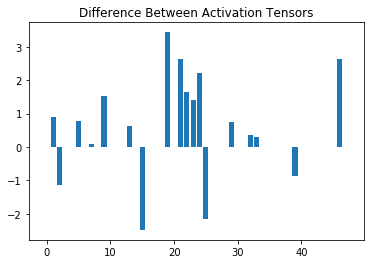

In [314]:
plt.bar(list(range(activations1.shape[-1])),activations2[0]-activations1[0])
plt.title('Difference Between Activation Tensors')
plt.show()

Looking at this plot, less than half of the activation values are different. In particular, 19 of the 48 are different. It's these deltas that turn the output value from positive to negative.

In [315]:
idx = np.where(np.abs(activations2[0]-activations1[0]) != 0)[0]
print(idx)
print(len(idx))

[ 1  2  5  7  9 13 15 19 21 22 23 24 25 29 32 33 39 41 46]
19


Let's take a look at the weights between the dense layer and the output layer.

In [316]:
model.layers[-1].get_weights()[0]

array([[-0.761328  ],
       [-0.38955086],
       [ 0.25164682],
       [-0.6806838 ],
       [-0.07136458],
       [ 0.3047489 ],
       [-0.6385073 ],
       [ 0.7835211 ],
       [-0.6200232 ],
       [-0.50170296],
       [-0.6577847 ],
       [ 0.29449475],
       [-0.5312026 ],
       [-0.6731623 ],
       [-0.7349575 ],
       [ 0.46927997],
       [-0.3264277 ],
       [-0.44371608],
       [ 0.71423584],
       [-0.85676545],
       [-0.20595877],
       [-0.46982706],
       [-0.5891263 ],
       [-1.1902316 ],
       [-0.3210534 ],
       [ 0.39882338],
       [ 0.6444201 ],
       [ 0.64645594],
       [ 0.35224345],
       [-0.983503  ],
       [ 0.74834156],
       [ 0.84980905],
       [ 0.43780574],
       [ 0.3155208 ],
       [ 0.7870005 ],
       [ 0.7171342 ],
       [ 0.8682368 ],
       [-0.20764922],
       [ 0.6079553 ],
       [ 0.22243673],
       [-0.4050627 ],
       [ 0.3087789 ],
       [-0.4238536 ],
       [ 1.3566773 ],
       [-0.24332698],
       [-0

We can also plot this data, which makes it easier to digest.

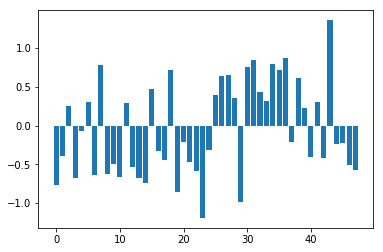

In [317]:
plt.bar(list(range(model.layers[-1].get_weights()[0].shape[0])),np.reshape(model.layers[-1].get_weights()[0],(48,)))
plt.show()

Looking at the weight vector, most of the weights in the first half are negative, and most of the weights in the second half are positive. 

Given that a sigmoid activation function is used, and all of the activations from the dense layer are positive, my intuition as to how this network operates is that numbers that are divisible by three tend to activate positions that correspond to positive weights, and numbers that are not divisible by three tend to activation positions that correspond to negative weights (resulting in large positive and negative numbers respectively, which translate to probabilities close to 1 and 0, respectively). 

Looking into the activations within the LSTM layer directly after the input is processed would help shed more light on to how this is done, but I feel that would be difficult due to the fact that the LSTM activation returns 32 outputs. In addition, these 32 outputs are fed to 48 dense nodes, which makes it even more complicated. However, we can at least make sense of the final layer before a classification is produced, which is what we've done here. In general, this is more complex than what I would designed as a human, but it is fascinating to get a glimpse of how the network operates.

As a final check, let's compute the output from the model and verify that we do get the correct classifications.

In [319]:
sum1 = np.dot(activations1[0],model.layers[-1].get_weights()[0]) + model.layers[-1].get_weights()[1]
print(sum1)
predict1 = 1/(1+np.exp(-sum1))
print(predict1)

[6.67093]
[0.9987344]


In [320]:
sum2 = np.dot(activations2[0],model.layers[-1].get_weights()[0]) + model.layers[-1].get_weights()[1]
print(sum2)
predict2 = 1/(1+np.exp(-sum2))
print(predict2)

[-6.4659343]
[0.00155312]


The number that is divisible by three generates an output of 6.67, which when passed through the sigmoid function generates a probability quite close to one. Likewise, the number that is not divisible by three generates an output of -6.47, which when passed through the sigmoid function generates a probability quite close to zero. As a final check, the delta between the activation returns a value of -13 (ignoring the bias terms), and this roughly corresponds to the drop in output value between 6.67 and -6.47.

In [321]:
sum_diff = np.dot(activations2[0]-activations1[0],model.layers[-1].get_weights()[0])
print(sum_diff)

[-13.136866]


## Conceptual Overview

As explained above, the final network structure is relatively simple. It consists of a single LSTM layer with 32 nodes, a dense layer with 48 nodes, and a output layer with a single node and sigmoid activation. Its purpose is to classify a digit as being divisible by three or not. It works by processing the digits of a number one at a time, maintaining a state between each one, and tuning the weights so that numbers that are divisible by three return a large positive output, and numbers that are not divisible by three return a large negative output (for the sigmoid activation to turn into a probability).

I was pleasantly surprised that the model was able to achieve 100% validation accuracy, and thus completely learn the 'divisible by 3' rule. The structure of the RNN, specifically how it is able to 'remember' previous inputs and use this memory to influence future calculations is extremely powerful. Even though this was a simple example, it was something I would not have thought a neural network was capable of beforehand. However, after learning how RNN's operate, it makes perfect sense that this type of rule set would be learnable. As we showed, RNNs are only capable of learning specific types of rules (the network struggled with divisibility by 7), but given a well posed problem, the results can be very powerful.